In [78]:
from math import nan
from re import compile

from matplotlib.figure import Figure
from matplotlib.pyplot import subplots
from pandas import read_csv, DataFrame
from seaborn import set_theme, lineplot

In [2]:
set_theme()

In [36]:
def target_f1(name: str) -> float:
    parts = name.split(" + ")
    for part in parts:
        if part.startswith("ground-truth"):
            match = compile(r"ground-truth\(F1<=(.*)\)").match(part)
            if not match:
                return 1.0
            return float(match.group(1))
    return nan

In [87]:
def differences(df: DataFrame) -> DataFrame:
    baseline = df[df["name"] == df["run"]].iloc[0]
    for measure_column in set(df.columns) - {"run", "name", "name_index", "target_f1"}:
        df[f"Δ{measure_column}"] = df[measure_column] - baseline[measure_column]
    return df

In [108]:
df: DataFrame = read_csv("data/metrics-reranking-f1.perquery.csv")
df["run"] = df["name"].apply(lambda name: name.split(" + ")[0])
df["target_f1"] = df["name"].apply(target_f1)
df.rename(columns={
    "rND@5(FIRST,SECOND,NEUTRAL)": "rND@5",
    "rKL@5(FIRST,SECOND,NEUTRAL)": "rKL@5",
    "rRD@5(FIRST,SECOND,NEUTRAL)": "rRD@5",
    "alpha_nDCG@5 rel.": "α-nDCG@5 rel.",
    "alpha_nDCG@5 qual.": "α-nDCG@5 qual.",
}, inplace=True)
df = df.groupby(["run", "qid"], sort=False, group_keys=True).apply(differences).reset_index(drop=True)
df.dropna(subset=["target_f1"], inplace=True)
df

,name,name_index,qid,nDCG@5 rel.,nDCG@5 qual.,F1,rKL@5,rND@5,rRD@5,α-nDCG@5 rel.,...,target_f1,ΔnDCG@5 qual.,Δα-nDCG@5 qual.,ΔrRD@5,Δα-nDCG@5 rel.,ΔnDCG@5 rel.,Δqid,ΔrND@5,ΔF1,ΔrKL@5
1,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,2,100,0.553,0.723,1.000,1.000,0.978,1.000,0.642,...,1.0,0.000,0.197,0.000,0.197,0.169,0,0.292,0.842,0.789
2,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,3,100,0.553,0.723,0.901,0.211,0.686,1.000,0.642,...,0.9,0.000,0.197,0.000,0.197,0.169,0,0.000,0.743,0.000
3,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,4,100,0.553,0.723,0.799,0.211,0.686,1.000,0.642,...,0.8,0.000,0.197,0.000,0.197,0.169,0,0.000,0.641,0.000
4,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,5,100,0.316,0.447,0.702,0.192,0.727,0.610,0.366,...,0.7,-0.276,-0.079,-0.390,-0.079,-0.068,0,0.041,0.544,-0.019
5,Aldo-Nadi seupd2122-kueri_rrf_reranked + groun...,6,100,0.345,0.684,0.602,0.269,1.000,0.633,0.401,...,0.6,-0.039,-0.044,-0.367,-0.044,-0.039,0,0.314,0.444,0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,5,95,0.277,0.361,0.699,1.000,1.000,1.000,0.370,...,0.7,0.000,0.122,0.000,0.122,0.085,0,0.000,0.541,0.000
3596,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,6,95,0.243,0.350,0.596,1.000,1.000,1.000,0.342,...,0.6,-0.011,0.094,0.000,0.094,0.051,0,0.000,0.438,0.000
3597,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,7,95,0.277,0.361,0.498,1.000,1.000,1.000,0.370,...,0.5,0.000,0.122,0.000,0.122,0.085,0,0.000,0.340,0.000
3598,Puss-in-Boots BM25-Baseline + ground-truth(F1<...,8,95,0.158,0.327,0.384,1.000,1.000,1.000,0.201,...,0.4,-0.034,-0.047,0.000,-0.047,-0.034,0,0.000,0.226,0.000


<AxesSubplot: xlabel='F1 score', ylabel='ΔnDCG@5'>

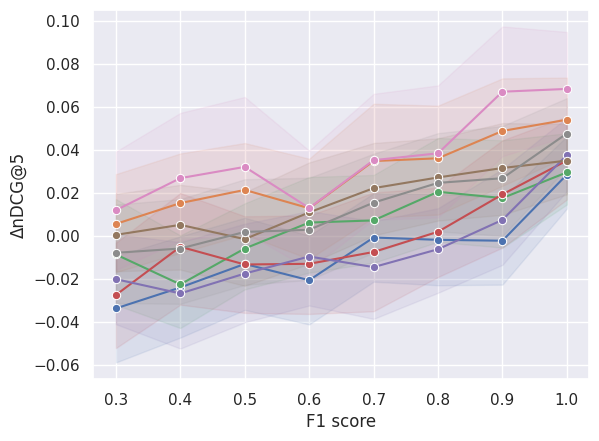

In [109]:
fig: Figure
fig, ax = subplots()
# fig.tight_layout()
lineplot(
    data=df,
    x="target_f1",
    # x="F1",
    y="ΔnDCG@5 rel.",
    # y="ΔnDCG@5 qual.",
    hue="run",
    legend=False,
    markers=True,
    style=0,
    ax=ax,
    err_style="band",
    err_kws={
        "alpha": 0.1,
    },
)
ax.set_xlabel("F1 score")
ax.set_ylabel("ΔnDCG@5")
fig.savefig("data/plot-reranking-f1-effectiveness.pdf")
fig.savefig("data/plot-reranking-f1-effectiveness.png")
ax

<AxesSubplot: xlabel='F1 score', ylabel='Δα-nDCG@5'>

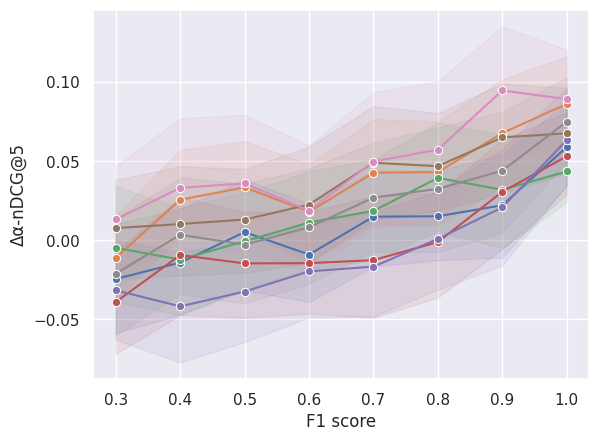

In [110]:
fig: Figure
fig, ax = subplots()
# fig.tight_layout()
lineplot(
    data=df,
    x="target_f1",
    # x="F1",
    y="Δα-nDCG@5 rel.",
    # y="ΔnDCG@5 qual.",
    hue="run",
    legend=False,
    markers=True,
    style=0,
    ax=ax,
    err_style="band",
    err_kws={
        "alpha": 0.1,
    },
)
ax.set_xlabel("F1 score")
ax.set_ylabel("Δα-nDCG@5")
fig.savefig("data/plot-reranking-f1-diversity.pdf")
fig.savefig("data/plot-reranking-f1-diversity.png")
ax

<AxesSubplot: xlabel='F1 score', ylabel='ΔrKL@5'>

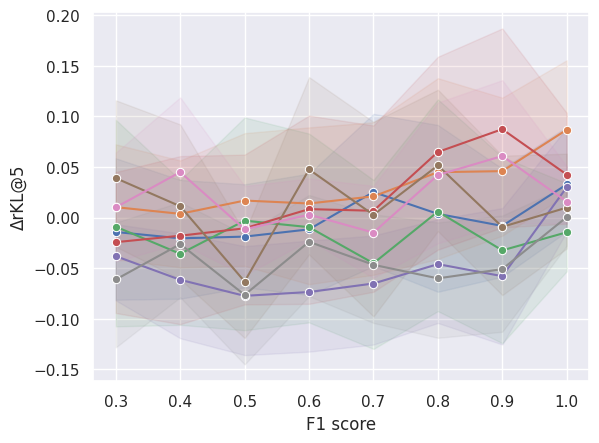

In [111]:
fig: Figure
fig, ax = subplots()
# fig.tight_layout()
lineplot(
    data=df,
    x="target_f1",
    # x="F1",
    # y="ΔrND@5",
    y="ΔrKL@5",
    # y="ΔrRD@5",
    hue="run",
    legend=False,
    markers=True,
    style=0,
    ax=ax,
    err_style="band",
    err_kws={
        "alpha": 0.1,
    },
)
ax.set_xlabel("F1 score")
fig.savefig("data/plot-reranking-f1-fairness.pdf")
fig.savefig("data/plot-reranking-f1-fairness.png")
ax